In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [3]:
df_test = pd.read_csv('/content/DA-HA test_log - test_log.csv')
df_customer_info = pd.read_csv('/content/DA-HA customers - customers.csv')

In [4]:
df_customers = df_test.merge(df_customer_info,on='customer_id')
df_customers.head(10)

,customer_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,city
0,315281,12/3/2019,Direct,Web,EN,NaN,Edge,1,0,M,32,Calgary
1,497851,12/4/2019,Ads,Web,EN,Google,Edge,0,1,M,21,Toronto
2,848402,12/4/2019,Ads,Web,EN,Facebook,Chrome,0,0,M,34,Calgary
3,290051,12/3/2019,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Toronto
4,548435,11/30/2019,Ads,Web,EN,Google,FireFox,0,1,M,19,Toronto
5,540675,12/3/2019,Direct,Mobile,EN,NaN,Android_App,0,1,F,22,Ottawa
6,863394,12/4/2019,SEO,Mobile,Other,NaN,Android_App,0,0,M,35,Toronto
7,527287,12/3/2019,Direct,Web,FR,NaN,Chrome,0,0,M,22,Calgary
8,261625,12/4/2019,Direct,Mobile,EN,NaN,Android_App,0,1,M,31,Kitchener
9,10427,12/4/2019,Ads,Mobile,EN,Facebook,Android_App,0,0,F,33,Toronto


In [5]:
df_customers.isna().sum()

customer_id              0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
city                     0
dtype: int64

In [6]:
df_customers.groupby('customer_id').count().mean()

date                1.000000
source              1.000000
device              1.000000
browser_language    1.000000
ads_channel         0.401206
browser             1.000000
conversion          1.000000
test                1.000000
sex                 1.000000
age                 1.000000
city                1.000000
dtype: float64

In [ ]:
df_customers.groupby('city').mean()

,customer_id,conversion,test,age
city,,,,
Calgary,500313.112143,0.079719,0.000000,27.150805
Edmonton,499840.637795,0.050258,0.498931,27.171003
Halifax,500975.507512,0.053399,0.491447,27.251227
Hamilton,500720.166876,0.049653,0.496066,27.167868
Kitchener,498211.608504,0.048634,0.501079,27.096908
London,498768.932190,0.049253,0.491013,27.142857
Montreal,499124.463245,0.051332,0.498927,27.142693
Oshawa,498102.368930,0.050765,0.497492,27.102875
Ottawa,499038.939789,0.049666,0.496194,27.094154


In [ ]:
def score_calculator (df_data,column_list,fair_thresh):
    first_result = df_customers.dropna(subset=['test','conversion']).groupby(['test']).mean().sort_values(by='test')['conversion']
    raw_score = np.round(100*(first_result[1]-first_result[0]),1)

    socre_map = {"Cateogory":[],"Test Score":[]}
    for column in column_list:

      df_data.dropna(subset=[column],inplace=True)
      diff_test = df_data.groupby(['test',column],as_index=False).mean()[[column,'test','conversion']]
      column_share = df_data.groupby([column],as_index=False).count()[[column,'customer_id']]
      test_share = df_data.groupby([column],as_index=False).mean()[[column,'test']]
      column_share['share'] = column_share['customer_id']/np.sum(column_share['customer_id'])

      do_calculus = diff_test.merge(column_share,on=column).merge(test_share,on=column).rename(columns={'test_y': 'test_share','test_x':'test'})

      final = do_calculus.where(
          abs(do_calculus['test_share']-0.5)<=fair_thresh
      ).dropna().head(20)

      final['weight'] = final['conversion']*final['share']
      treatment_df = final.where(final['test']==1)
      treatment_score = np.round(100*np.sum(treatment_df['weight'])/np.sum(treatment_df['share']),2)
      control_df = final.where(final['test']==0)
      control_score = np.round(100*np.sum(control_df['weight'])/np.sum(control_df['share']),2)
      test_score = np.round(treatment_score - control_score,1)
      socre_map["Cateogory"].append(column)
      socre_map["Test Score"].append(test_score)

    result = pd.DataFrame(socre_map)
    avg = np.mean(result['Test Score'])
    result['NotFair'] = result['Test Score'].apply(lambda x:int(abs(x/raw_score - 1)>=fair_thresh))
    if np.sum(result['NotFair']>=1):
      print(result)
      return False
    
    else:
      print(result)
      return True

In [ ]:
score_calculator(df_customers,['city','browser','device','sex','date','browser_language','source','age'],0.1)

          Cateogory  Test Score  NotFair
0              city        -0.1        1
1           browser        -1.2        0
2            device        -1.2        0
3               sex        -1.2        0
4              date        -1.2        0
5  browser_language        -1.2        0
6            source        -1.2        0
7               age        -1.1        0


False

Text(0.5, 1.0, 'conversion rate in groups per city')

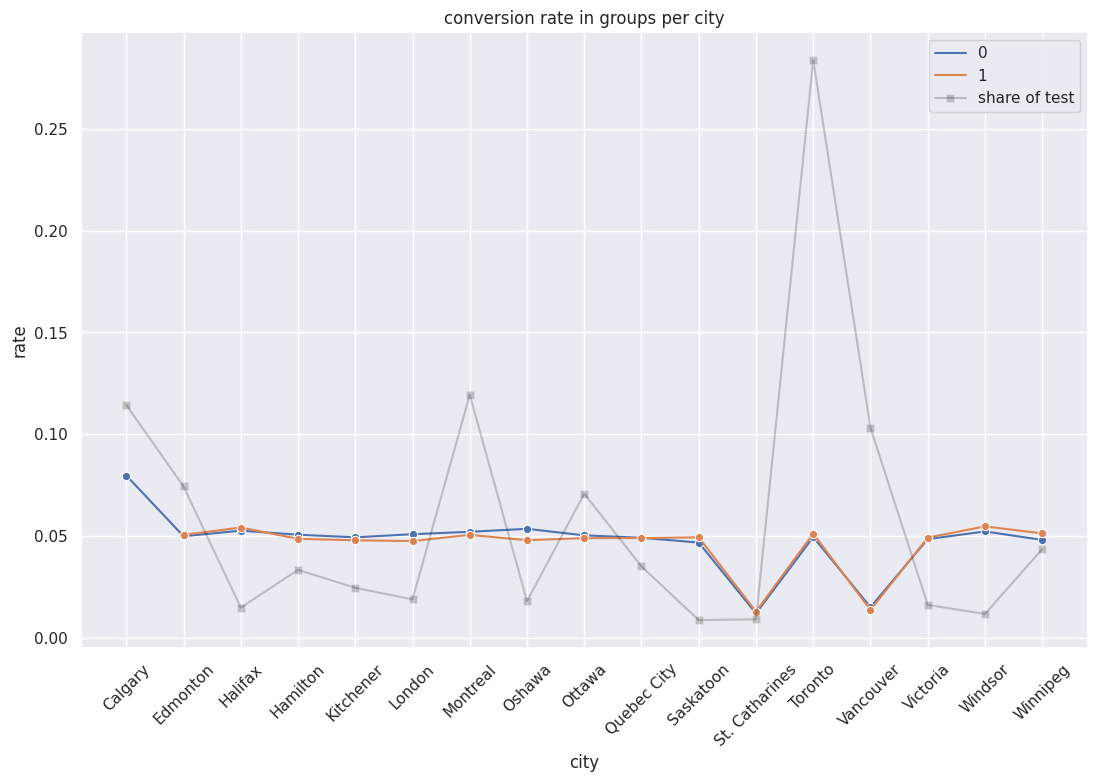

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(13,8)})
sns.lineplot(data = diff_test,x='city',y='conversion' ,marker='o',hue='test')
sns.lineplot(data = city_share,x='city',y='share' ,marker='s',color='black',alpha=0.2,label='share of test')

plt.ylabel('rate')
plt.xticks(rotation=45)
plt.title('conversion rate in groups per city')

In [ ]:
def groupPlot(df,column):
  #df.dropna(subset=[column],inplace=True)
  to_plot = df.groupby([column],as_index=False).mean()[[column,'test','conversion']].sort_values(by='test')
  matplotlib.rc_file_defaults()
  ax1 = sns.set_style(style=None, rc=None )

  fig, ax1 = plt.subplots(figsize=(13,8))

  sns.lineplot(data = to_plot,x=column,y='conversion' ,marker='o', sort = True, ax=ax1,label='conversion rate')
  ax2 = ax1.twinx()

  sns.barplot(data = to_plot, x=column, y='test', alpha=0.5, ax=ax2,color='red',label='treatment share')
  ax2.tick_params(axis='x', rotation=45)
  ax1.tick_params(axis='x', rotation=45)
  ax2.set_ylim([0,2])
  ax1.set_ylabel('conversion rate')
  ax2.set_ylabel('treatment share')

  plt.axhline(y=.5,color='black')
  plt.grid()

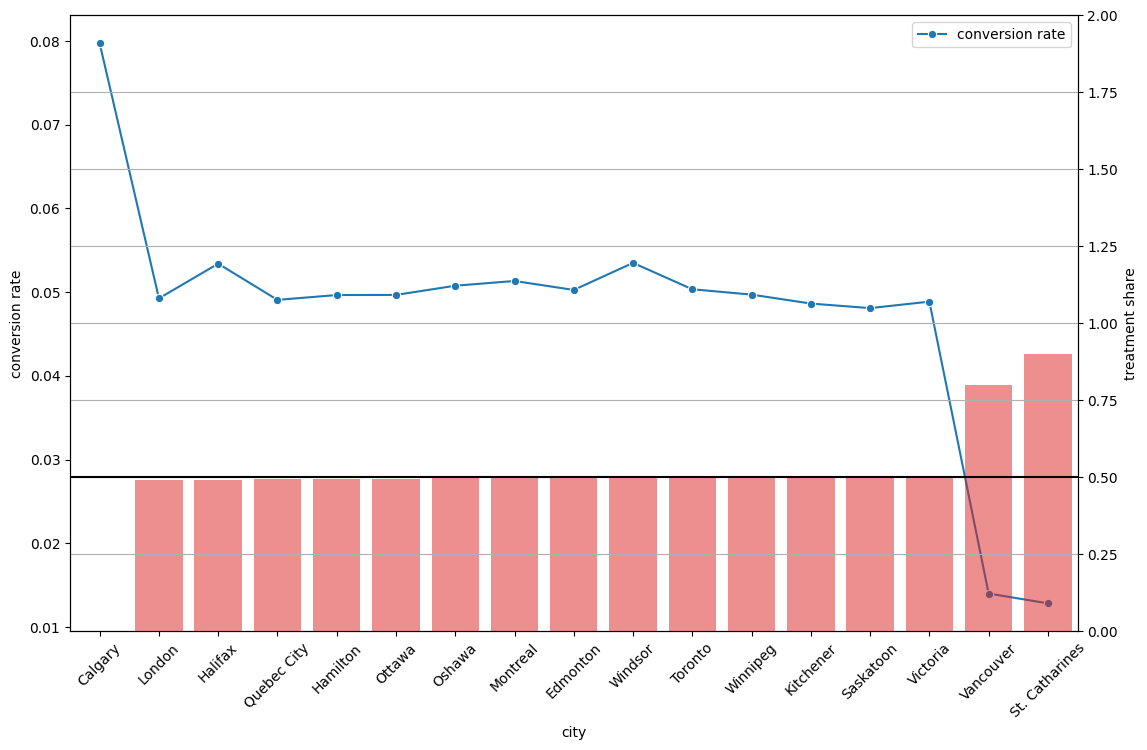

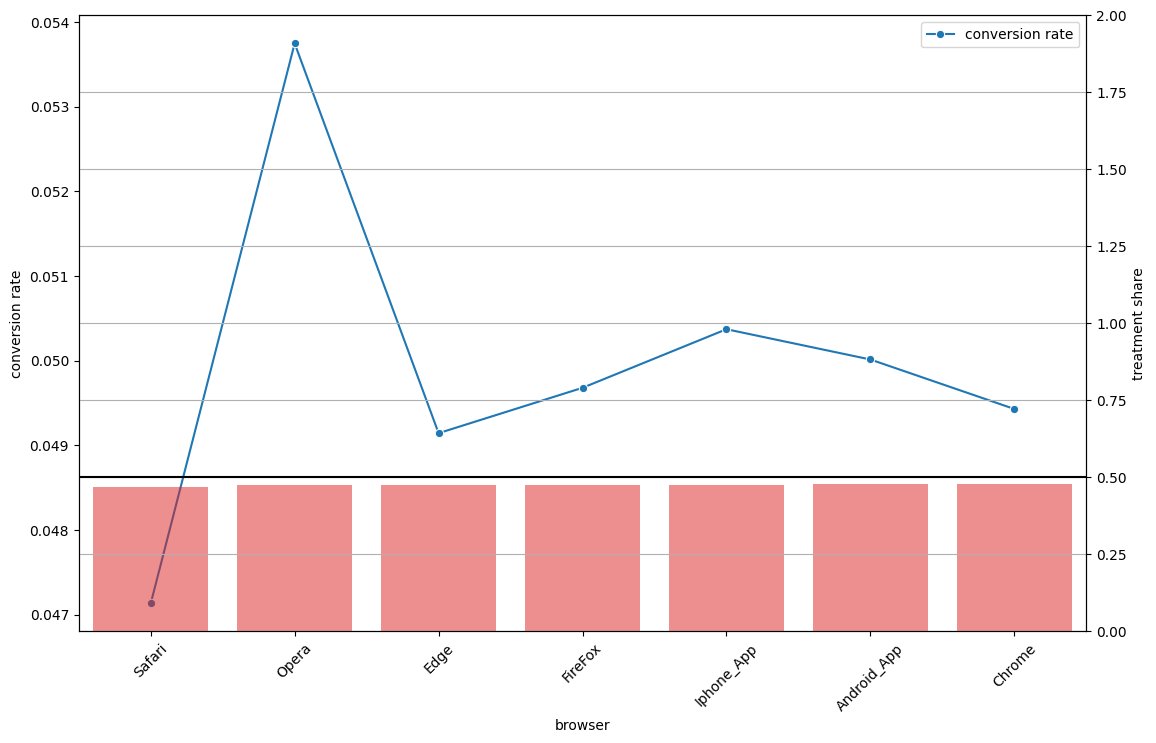

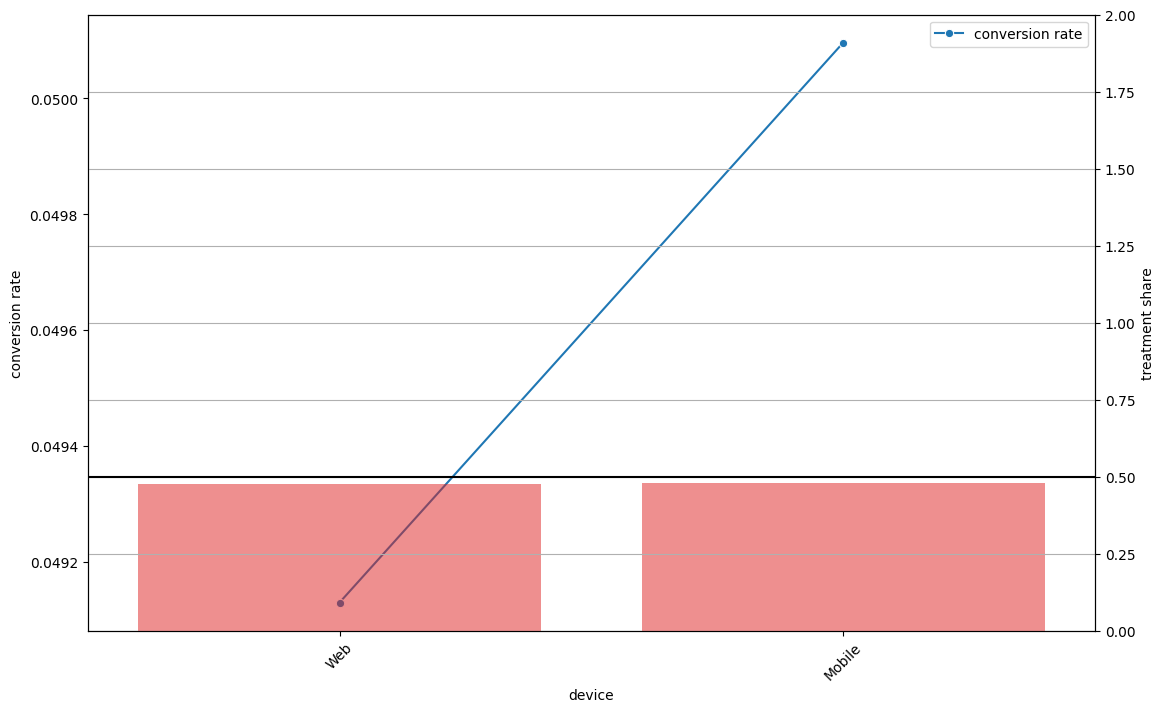

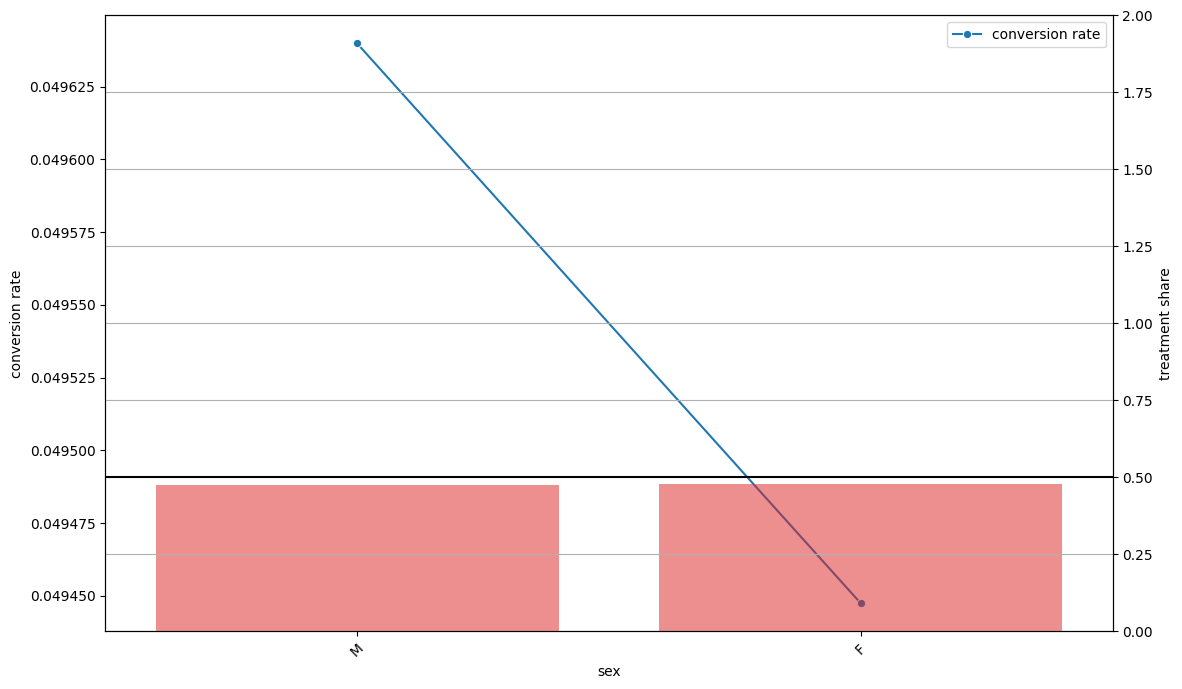

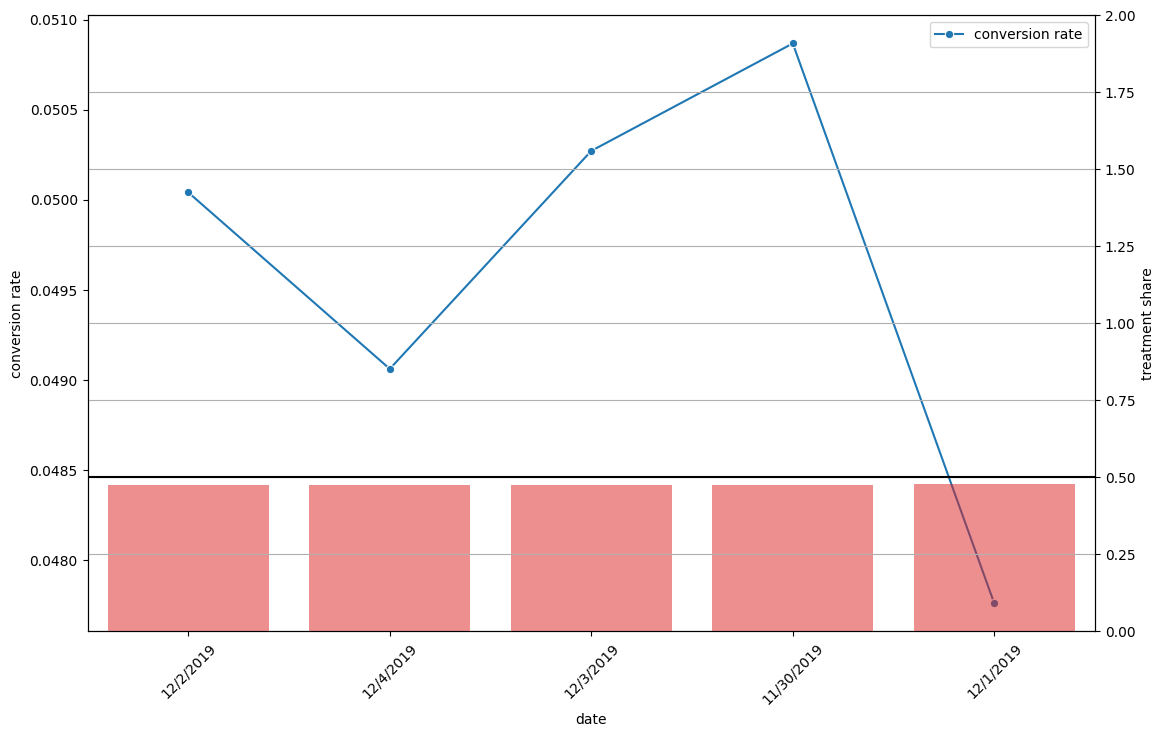

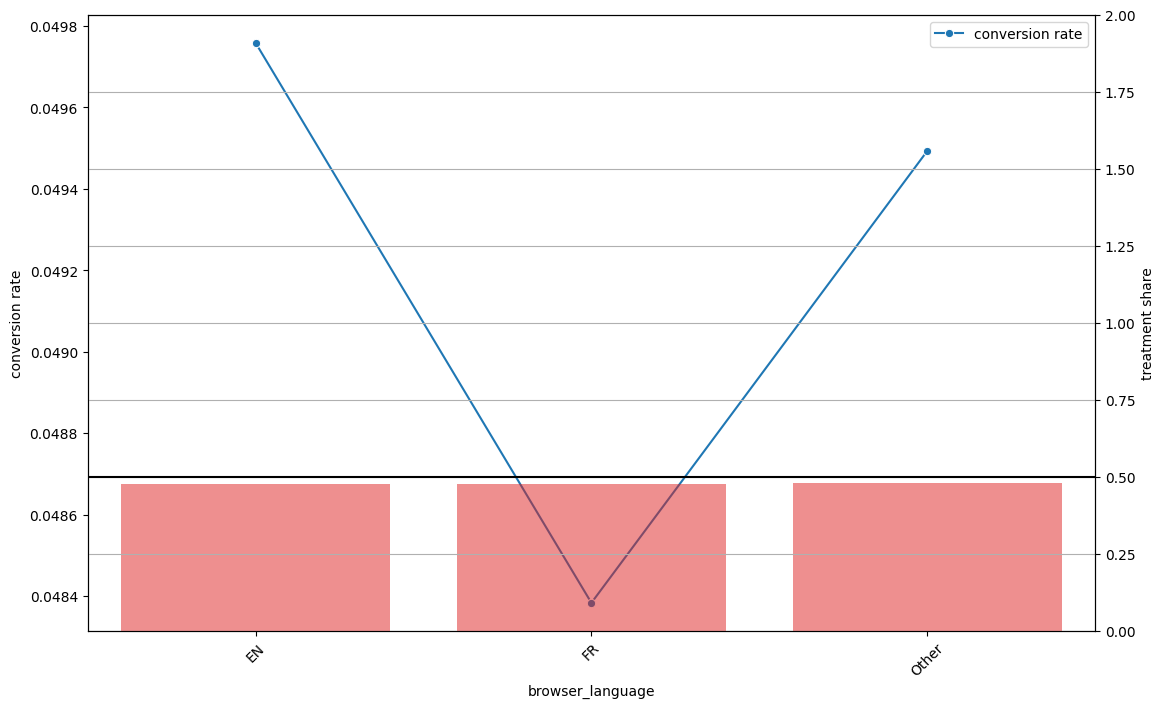

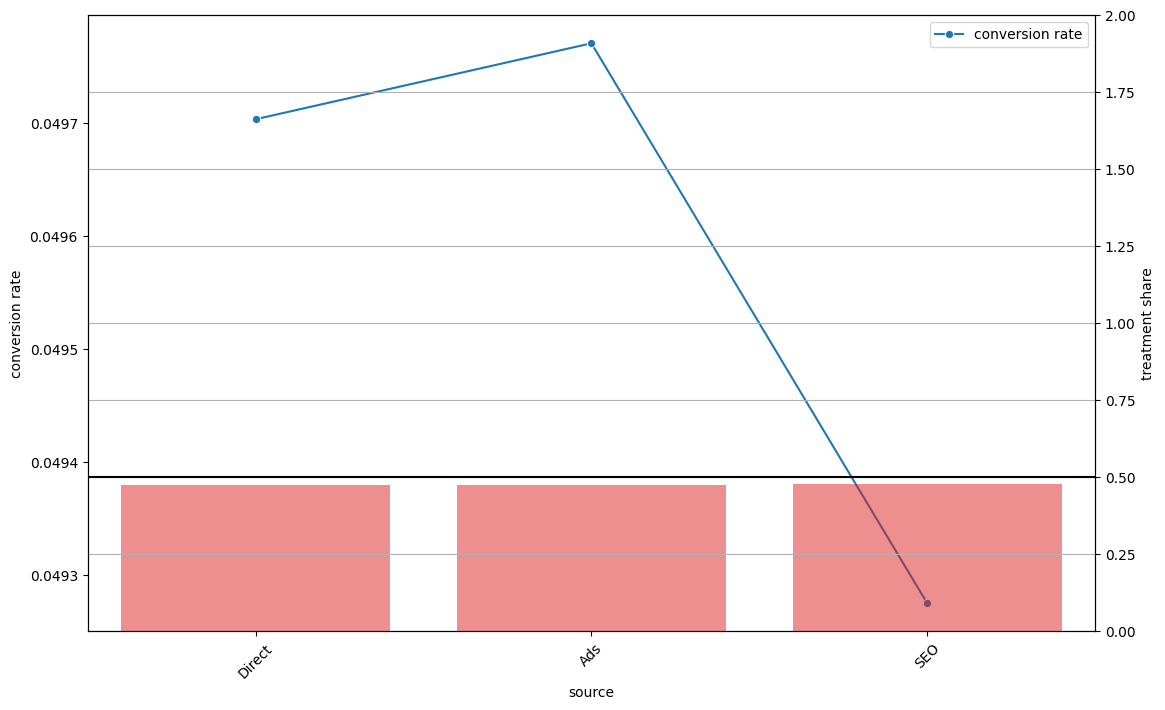

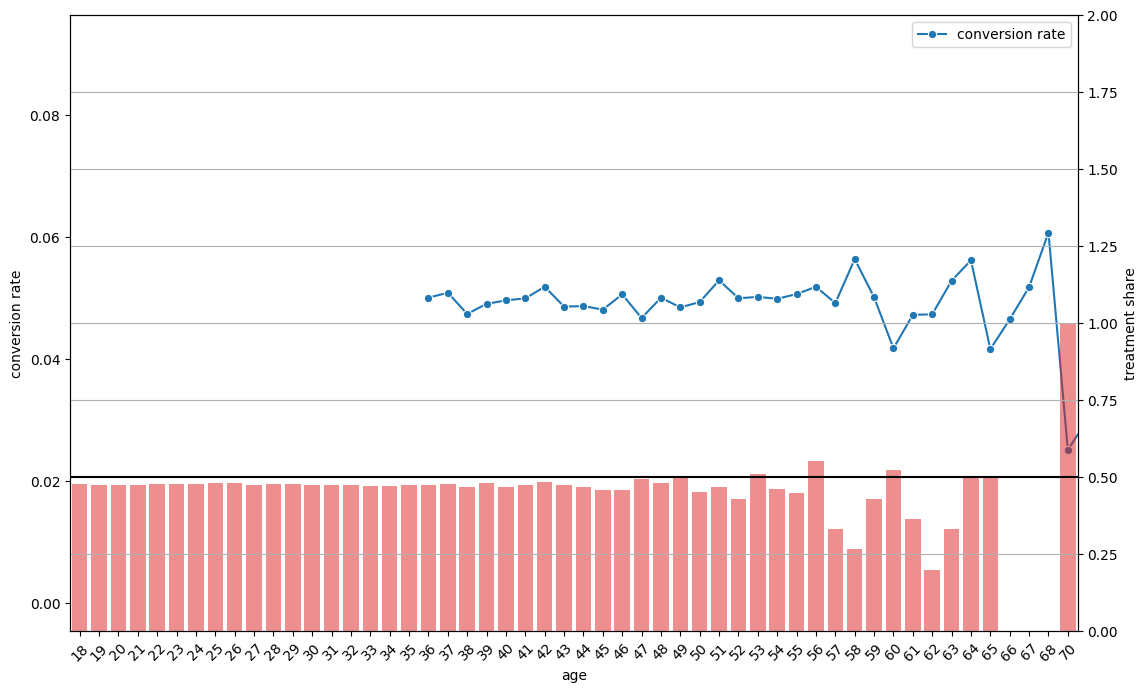

In [ ]:
columns = ['city','browser','device','sex','date','browser_language','source','age']

for column in columns:
  groupPlot(df_customers,column)

In [ ]:
filter1 = df_customers["city"]!= 'St. Catharines'
filter2 = df_customers["city"]!= 'Vancouver'
filter3 = df_customers["city"]!= 'Calgary'


df_filtered = df_customers.where(filter1 & filter2 & filter3)
df_filtered.dropna(subset=['city']).groupby(['test']).mean()

,customer_id,conversion,age
test,,,
0.0,500532.731919,0.050148,27.143961
1.0,499435.921289,0.050413,27.114296


In [7]:
import statsmodels.formula.api as sm
X_data = df_customers[['test','city','age','customer_id']]
X_data['conversion'] = df_customers['conversion']

'y ~ C(Location, Treatment(reference="China"))'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'y ~ C(Location, Treatment(reference="China"))'

In [8]:
result = sm.ols(formula="conversion ~ test ", data=X_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     331.0
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           6.09e-74
Time:                        10:43:04   Log-Likelihood:                 49421.
No. Observations:              452867   AIC:                        -9.884e+04
Df Residuals:                  452865   BIC:                        -9.882e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0552      0.000    123.788      0.0

In [ ]:
def refrence_relevel(a,i,j):
  b, c = a.iloc[i].copy(), a.iloc[j].copy()
  a.iloc[i],a.iloc[j] = c,b
  return a

In [9]:
result = sm.ols(formula='conversion ~ city+ test' , data=X_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     141.0
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:12:19   Log-Likelihood:                 50451.
No. Observations:              452867   AIC:                        -1.009e+05
Df Residuals:                  452849   BIC:                        -1.007e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [ ]:
result = sm.ols(formula='conversion ~ C(city, Treatment(reference="Toronto"))+ test' , data=X_data).fit()
print(result.summary())